In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
from config import ATTR_TO_INDEX
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import data
import transects
import face_recognition
import sklearn.metrics
from matching import *
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox


df = data.load_all_labs()
df = df.set_index('fname_id')

DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f]
fname_ids = np.array([f[:-4] for f in fname_nps])

# trim df to only have the relevant ids
df = df.loc[fname_ids]

# load the linear model in latent space
coefs, intercepts = transects.get_directions()
coefs = np.array(coefs).squeeze()
intercepts = np.array(intercepts)


# load latents and calculate dists
print('loading latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = lats @ coefs.T + intercepts.T
weights = np.zeros(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)

print('calculating dists...')
dists = get_dists(vecs)
print('done!')

# load pairwise facial dicts
dists_facial_dict = pkl.load(open('processed/13_facial_dists_pairwise.pkl', 'rb'))

# do matching

### find matching for an im

In [ ]:
# img 38 is a good gender example
for im_idx in range(38, 40):
    # if all images are calculated, then this is just 5-char string of im_idx + 1
    fname_id = fname_ids[im_idx] 
    
    # idxs
    dists_im = dists[im_idx]
    
    # select subset of indices to use for matching
    idxs = np.ones(df.shape[0]).astype(bool)
    idxs = (df['gender'] > 0).values
#     idxs = (df['race'] == 'Black').values
#     idxs = (df['Eyeglasses'] > 0).values
    dists_im = dists_im[idxs]
    fname_ids_for_matching = fname_ids[idxs]    
    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    # print(closest_matches_fnames)
    
    # load images
    N_MATCHES_TO_PLOT = 5
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches, dpi=50)
    plt.show()
    # print(closest_matches, closest_matches_fnames)
# show_matches(dists, DIR_ORIG, DIR_GEN, im_nums=range(5, 10))

**simple dim reduction**

In [51]:
lats.shape
N_IMS = 1000

1000it [00:01, 859.61it/s]


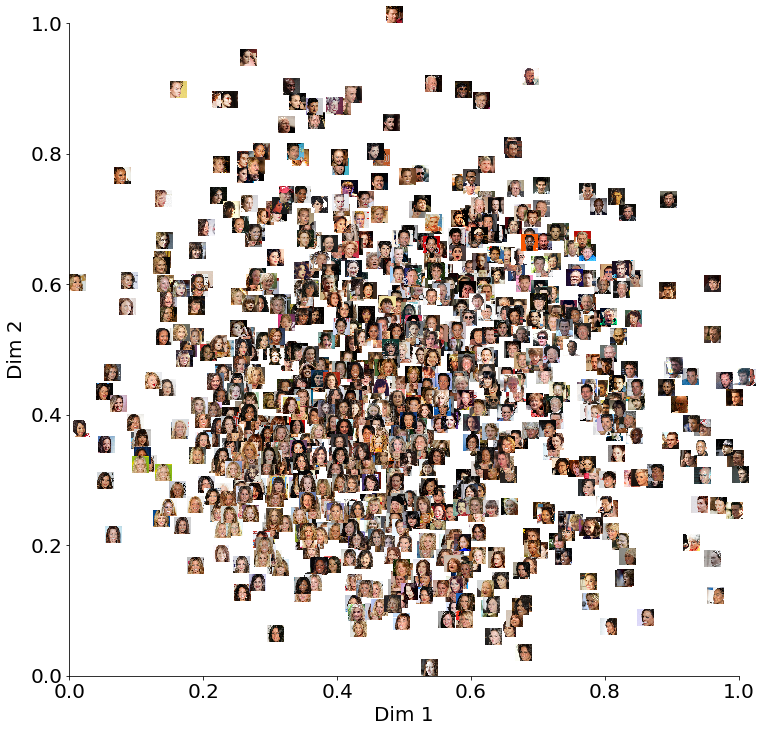

In [63]:
def plot_image(xs, ys, im):
    '''Note: should normalize x/y coords to 0-1 before plotting
    '''
    for idx, (x, y) in tqdm(enumerate(zip(xs, ys))):
        bb = Bbox.from_bounds(x, y, IM_SIZE, IM_SIZE)  
        bb2 = TransformedBbox(bb, ax.transData)
        bbox_image = BboxImage(bb2, origin=None, clip_on=False)
        bbox_image.set_data(im[idx])
#          bbox_image.set_alpha(1.0)
        ax.add_artist(bbox_image)
    return ax

# plot
IM_SIZE = 0.025
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ims = [mpimg.imread(oj(DIR_ORIG, f))[::4, ::4] for f in df.fname_final[:N_IMS]]
l = sklearn.decomposition.PCA(n_components=2).fit_transform(lats[:N_IMS])
# l = sklearn.manifold.TSNE().fit_transform(lats[:N_IMS])
l = (l - l.min(axis=0)) / (l.max(axis=0) - l.min(axis=0))
N_PLOT = 1000
ax = plot_image(l[:N_PLOT, 0], l[:N_PLOT, 1], ims)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
# plt.xlim((0.5, 1))
# plt.ylim((0, 0.5))
plt.show()

# plots for specific ids/matches

**make some plots for a specific match**

In [ ]:
im_idx = 38 # img 38 is a good gender example
fname_id2 = '02638' # this is the match
# if all images are calculated, then this is just 5-char string of im_idx + 1
fname_id = fname_ids[im_idx] 


# idxs
dists_im = dists[im_idx]

im = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
im2 = mpimg.imread(oj(DIR_ORIG, f'{fname_id2}.jpg'))

d1 = df[df.id == df.loc[fname_id].id]
d2 = df[df.id == df.loc[fname_id2].id]



util.plot_row([im, im2])
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in d1.fname_final])
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in d2.fname_final])

**look at images / reconstructions of the same person**

In [ ]:
d = df[df['count_with_this_id'] >= df['count_with_this_id'].max() - 1]
dd = d[d.id == d.iloc[0].id]
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in dd.fname_final][:5])
util.plot_row([mpimg.imread(oj(DIR_GEN, f'{index}.png')) for index in dd.index][:5])

# evaluate matching with metrics

**how often do we return the same id?**

In [50]:
d = df[df['count_with_this_id'] > 1]
# print(d.shape)

acc_top1 = []
acc_top5 = []
acc_top10 = []
for im_idx in tqdm(range(1000)):
    id_orig = df.iloc[im_idx].id
    
    # idxs
    dists_im = dists[im_idx]
    matched_idxs = np.argsort(dists_im)
    matched_ids = df.iloc[matched_idxs].id.values # note - this needs to be df not d to get the proper indices from dists
    acc_top1.append(id_orig == matched_ids[0])
    acc_top5.append(id_orig in matched_ids[:5])
    acc_top10.append(id_orig in matched_ids[:10])
print('top1', np.mean(acc_top1), 'top5', np.mean(acc_top5), 'top10', np.mean(acc_top10))

100%|██████████| 1000/1000 [00:09<00:00, 100.33it/s]
